# Introduction

## Aim

Analyze DNN architectures of the new framework, that is, when a single DNN is used over a merged dataset. 

## Code setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
import os
import pickle
import math
from scipy.io import loadmat

In [2]:
path = '/media/maousi/Raw/lvad/dnns'

# Training history & test predictions


In [3]:
folders = list(filter(
    lambda folder: os.path.isdir(folder),
    map(
        lambda f: os.path.join(path, f),
        os.listdir(path)
    )
))

In [4]:
names = ['Param_LeftVentricle_Emax0', 'Param_LeftVentricle_EmaxRef0',
                      'Param_LeftVentricle_AGain_Emax', 'Param_LeftVentricle_kE']
def read_ys(fp):
    return pd.read_csv(fp, header=None, sep=' ',
                       names=names)

In [5]:
# Data structure: dictionnary:
# - key = dataset folder
# - value = dictionnary:
#      - history -> dictionnary of history (e.g. 'loss' -> list)
#      - ytest -> dataframe
#      - rpm -> list of rpms
data = {}
for f in folders:
    if len(os.listdir(f)) == 0 or f.endswith('_test'):
        continue
    sub = {}
    with open(os.path.join(f, 'history.bin'), 'rb') as file:
        sub['history'] = pickle.load(file)
    print(f)
    sub['ytest'] = read_ys(os.path.join(f, 'Ytest.txt'))
    sub['ytesthat'] = read_ys(os.path.join(f, 'Ytestpred.txt'))
    data[f] = sub

/media/maousi/Raw/lvad/dnns/dnn_4_layers_64_neurons
/media/maousi/Raw/lvad/dnns/dnn_10_layers_128_neurons
/media/maousi/Raw/lvad/dnns/dnn_10_layers_16_neurons
/media/maousi/Raw/lvad/dnns/dnn_10_layers_32_neurons
/media/maousi/Raw/lvad/dnns/dnn_10_layers_64_neurons
/media/maousi/Raw/lvad/dnns/dnn_12_layers_128_neurons
/media/maousi/Raw/lvad/dnns/dnn_12_layers_16_neurons
/media/maousi/Raw/lvad/dnns/dnn_12_layers_32_neurons
/media/maousi/Raw/lvad/dnns/dnn_12_layers_64_neurons
/media/maousi/Raw/lvad/dnns/dnn_3_layers_128_neurons
/media/maousi/Raw/lvad/dnns/dnn_3_layers_256_neurons
/media/maousi/Raw/lvad/dnns/dnn_3_layers_32_neurons
/media/maousi/Raw/lvad/dnns/dnn_3_layers_64_neurons
/media/maousi/Raw/lvad/dnns/dnn_4_layers_128_neurons
/media/maousi/Raw/lvad/dnns/dnn_4_layers_256_neurons
/media/maousi/Raw/lvad/dnns/dnn_4_layers_32_neurons
/media/maousi/Raw/lvad/dnns/dnn_5_layers_128_neurons
/media/maousi/Raw/lvad/dnns/dnn_5_layers_256_neurons
/media/maousi/Raw/lvad/dnns/dnn_5_layers_32_neur

In [6]:
def parse_fname(name):
    ls = name.split('_')
    return int(ls[-4]), int(ls[-2])

In [7]:
dnns = []
for k in data:
    hist = data[k]['history']
    layers, neurons = parse_fname(k)
    item = {'layers': layers, 'neurons': neurons}
    for key, val in hist.items():
        item[key] = val[-1]
    dnns.append(item)

dnns = pd.DataFrame(dnns).sort_values('val_mae', ignore_index=True)
dnns = dnns.loc[:, ['layers', 'neurons', 'loss', 'val_loss', 'mae', 'val_mae']]
dnns.columns = [e.replace('_', ' ') for e in dnns.columns]
dnns

layers  neurons      loss  val loss       mae   val mae
0        3      256  0.007702  0.009389  0.056046  0.059711
1        5      128  0.009074  0.009528  0.060467  0.061168
2        5       64  0.010202  0.009960  0.064165  0.063030
3        6      256  0.008222  0.010712  0.057531  0.063260
4        4      128  0.008704  0.010042  0.059304  0.063485
5        4      256  0.008447  0.010456  0.058652  0.063897
6        3      128  0.008469  0.009734  0.058668  0.064073
7        6       64  0.010382  0.010723  0.064662  0.065413
8        4       64  0.011188  0.011740  0.067055  0.068328
9        3       64  0.010691  0.012094  0.066930  0.068908
10       5      256  0.007923  0.011561  0.056623  0.069249
11       8      128  0.010078  0.012927  0.063564  0.071554
12       4       32  0.013287  0.013003  0.073584  0.072981
13       6      128  0.009485  0.013131  0.062320  0.075508
14       8       64  0.012227  0.014259  0.069773  0.075920
15       5       32  0.015303  0.015418  0.078613  0.080253
16      12       64  0.020750  0.020815  0.087496  0.085525
17      10       32  0.021263  0.020848  0.089424  0.086156
18      12       32  0.021182  0.020980  0.088656  0.086661
19      10      128  0.020605  0.021429  0.088016  0.087805
20       3       32  0.015663  0.016309  0.080934  0.088400
21      10       64  0.020867  0.021203  0.088028  0.089474
22      12       16  0.021945  0.021508  0.093114  0.090465
23       6       32  0.019706  0.020356  0.087179  0.091293
24       8       32  0.022797  0.022388  0.097288  0.094862
25       8       16  0.021624  0.022867  0.092718  0.097639
26      10       16  0.023434  0.022980  0.100542  0.097691
27      12      128  0.020277  0.023349  0.087009  0.101225

In [45]:
caption = """Values for DNN architecture selection, sorted by the validation mean absolute error."""
label = """tab:dnn_architectures"""

#formatter = lambda n: np.format_float_scientific(n, precision=2, trim='k')
formatter = '{:.4f}'.format

latex = dnns.to_latex(float_format=formatter, caption=caption, label=label)
latex = latex.replace('\\toprule', '\hline')
latex = latex.replace('\\midrule', '\hline')
latex = latex.replace('\\bottomrule', '\hline')
with open('data/dnn_architectures2.tex', 'w') as f:
    f.write(latex)
print(latex)

\begin{table}
\centering
\caption{Values for DNN architecture selection, sorted by the validation mean absolute error.}
\label{tab:dnn_architectures}
\begin{tabular}{lrrrrrr}
\hline
{} &  layers &  neurons &   loss &  val loss &    mae &  val mae \\
\hline
0  &       3 &      256 & 0.0077 &    0.0094 & 0.0560 &   0.0597 \\
1  &       5 &      128 & 0.0091 &    0.0095 & 0.0605 &   0.0612 \\
2  &       5 &       64 & 0.0102 &    0.0100 & 0.0642 &   0.0630 \\
3  &       6 &      256 & 0.0082 &    0.0107 & 0.0575 &   0.0633 \\
4  &       4 &      128 & 0.0087 &    0.0100 & 0.0593 &   0.0635 \\
5  &       4 &      256 & 0.0084 &    0.0105 & 0.0587 &   0.0639 \\
6  &       3 &      128 & 0.0085 &    0.0097 & 0.0587 &   0.0641 \\
7  &       6 &       64 & 0.0104 &    0.0107 & 0.0647 &   0.0654 \\
8  &       4 &       64 & 0.0112 &    0.0117 & 0.0671 &   0.0683 \\
9  &       3 &       64 & 0.0107 &    0.0121 & 0.0669 &   0.0689 \\
10 &       5 &      256 & 0.0079 &    0.0116 & 0.0566 &   0.069

In [9]:
final_val_loss = [
    (folder, data[folder]['history']['val_loss'][-1]) for folder in data
]
final_val_loss = sorted(final_val_loss, key=lambda e: e[1])
best_sorted = [e[0] for e in final_val_loss]
best_sorted[:5]

['/media/maousi/Raw/lvad/dnns/dnn_3_layers_256_neurons',
 '/media/maousi/Raw/lvad/dnns/dnn_5_layers_128_neurons',
 '/media/maousi/Raw/lvad/dnns/dnn_3_layers_128_neurons',
 '/media/maousi/Raw/lvad/dnns/dnn_5_layers_64_neurons',
 '/media/maousi/Raw/lvad/dnns/dnn_4_layers_128_neurons']

In [10]:
def parse_name(fname):
    ls = fname.split('_')
    return f'L={ls[-4]}, N={ls[-2]}'

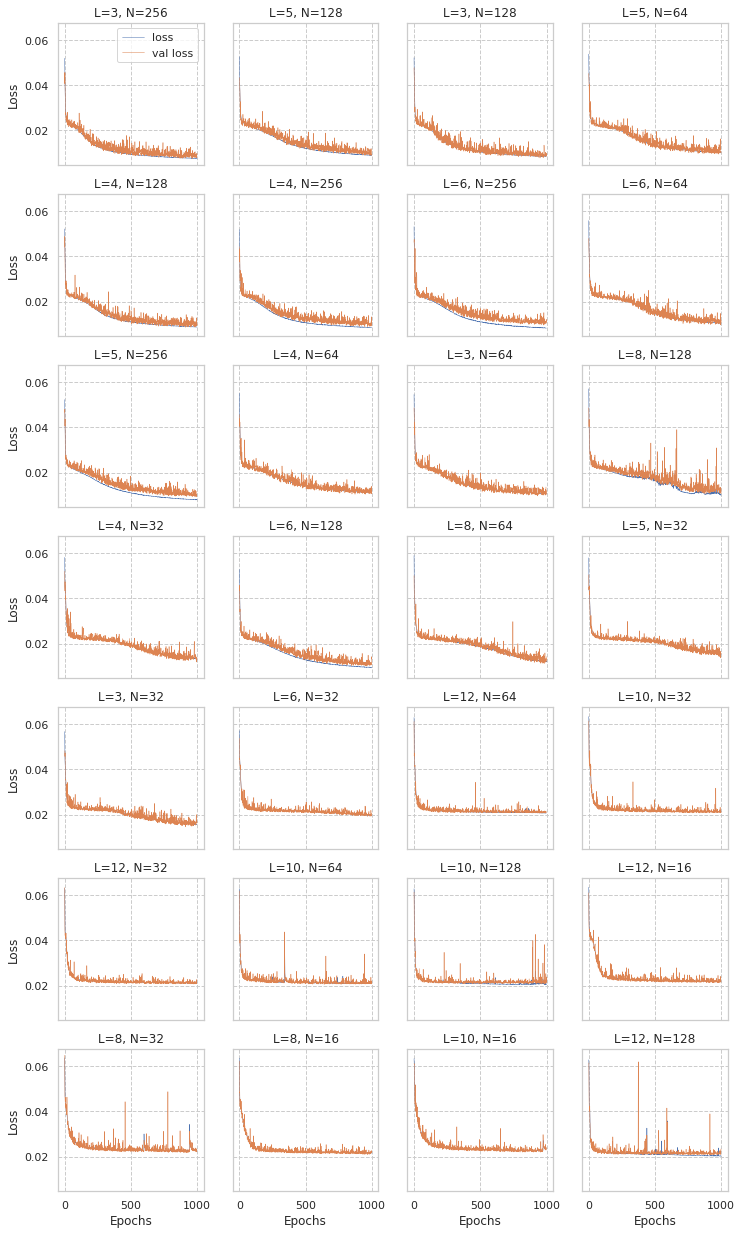

In [11]:
ncol = 4
nrow = math.ceil(len(data) / ncol)
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 3*nrow+.5), sharex=True, sharey=True)

for ax, folder in zip(axes.ravel(), best_sorted):
    ax.plot(data[folder]['history']['loss'], lw=.5, label='loss')
    ax.plot(data[folder]['history']['val_loss'], lw=.5, label='val loss')
    ax.set_title(parse_name(folder))
    ax.grid(ls='--')

axes[0,0].legend()
for a in axes[-1, :]:
    a.set_xlabel('Epochs')
for a in axes[:, 0]:
    a.set_ylabel('Loss')

plt.savefig('figs/dnn_architectures_bis2.pdf')

## Concatenate test predictions



In [35]:
params = next(iter(data.items()))[1]['ytest'].columns
params_pretty = list(map(lambda v: '_'.join(v.split('_')[2:]), params))
params_dic = dict(zip(params, params_pretty))
params_dic

{'Param_LeftVentricle_Emax0': 'Emax0',
 'Param_LeftVentricle_EmaxRef0': 'EmaxRef0',
 'Param_LeftVentricle_AGain_Emax': 'AGain_Emax',
 'Param_LeftVentricle_kE': 'kE'}

In [36]:
Y = []
for fp in data:
    y = data[fp]['ytest'].rename(columns=params_dic)
    yhat = data[fp]['ytesthat'].rename(columns=params_dic)
    y = y.join(yhat, rsuffix='_hat')
    layers, neurons = parse_fname(fp)
    y['layers'] = layers
    y['neurons'] = neurons
    Y.append(y)
Y = pd.concat(Y, ignore_index=True)

# Compute relative errors
for p in params_pretty:
    Y[p+'_relerr'] = np.abs(Y[p] - Y[p+'_hat']) / Y[p]
Y

Emax0  EmaxRef0  AGain_Emax        kE  Emax0_hat  EmaxRef0_hat  \
0       1.826396  2.360589    0.467659  0.012638   1.732973      2.363038   
1       2.696736  0.395388    0.397031  0.013295   2.410054      0.364238   
2       0.568347  2.003394    0.380238  0.011284   0.364980      2.107069   
3       1.506046  1.658621    0.242821  0.011479   1.570536      1.843447   
4       2.384774  0.374431    0.459330  0.012726   2.437983      0.466870   
...          ...       ...         ...       ...        ...           ...   
293995  0.317691  1.333223    0.270735  0.013712   0.298857      1.300356   
293996  0.799416  0.313290    0.257609  0.012913   0.830015      0.256916   
293997  1.951873  0.266491    0.292459  0.011946   2.064538      0.309196   
293998  1.437731  0.919122    0.451908  0.011669   1.576154      1.093382   
293999  1.950040  2.164606    0.412949  0.012290   2.039673      2.226833   

        AGain_Emax_hat    kE_hat  layers  neurons  Emax0_relerr  \
0             0.465213  0.012546       4       64      0.051151   
1             0.305093  0.013155       4       64      0.106307   
2             0.347210  0.011384       4       64      0.357821   
3             0.258940  0.011778       4       64      0.042821   
4             0.458630  0.012865       4       64      0.022312   
...                ...       ...     ...      ...           ...   
293995        0.307384  0.013857       8       64      0.059285   
293996        0.283789  0.013176       8       64      0.038276   
293997        0.311028  0.011885       8       64      0.057721   
293998        0.358649  0.011862       8       64      0.096279   
293999        0.342760  0.012294       8       64      0.045965   

        EmaxRef0_relerr  AGain_Emax_relerr  kE_relerr  
0              0.001037           0.005230   0.007232  
1              0.078782           0.231563   0.010492  
2              0.051750           0.086860   0.008881  
3              0.111433           0.066385   0.026041  
4              0.246877           0.001524   0.010924  
...                 ...                ...        ...  
293995         0.024652           0.135368   0.010617  
293996         0.179941           0.101627   0.020378  
293997         0.160247           0.063492   0.005090  
293998         0.189594           0.206368   0.016530  
293999         0.028747           0.169970   0.000347  

[294000 rows x 14 columns]

Split-apply-combine to get the test MAE for all 4 parameters:

In [37]:
relerr = Y.groupby(['layers', 'neurons']).mean()
# Keep only relative errors
relerr = relerr.loc[:, filter(lambda n: n.endswith('_relerr'), relerr.columns)]
relerr

Emax0_relerr  EmaxRef0_relerr  AGain_Emax_relerr  kE_relerr
layers neurons                                                             
3      32           0.133737         0.107753           0.159610   0.018070
       64           0.117147         0.080343           0.131139   0.010517
       128          0.101375         0.080646           0.123839   0.010802
       256          0.094408         0.071763           0.120594   0.008326
4      32           0.113434         0.077400           0.144565   0.011811
       64           0.102795         0.087581           0.132396   0.009959
       128          0.095728         0.078211           0.119443   0.010128
       256          0.097884         0.082189           0.121448   0.010011
5      32           0.119557         0.097625           0.161441   0.013311
       64           0.100696         0.075786           0.124319   0.009325
       128          0.098540         0.075558           0.120449   0.009669
       256          0.093777         0.085349           0.130504   0.013235
6      32           0.101995         0.095155           0.198934   0.014930
       64           0.094869         0.079212           0.134084   0.010774
       128          0.133227         0.087312           0.133391   0.013886
       256          0.100803         0.086573           0.124949   0.008342
8      16           0.160664         0.090640           0.212350   0.009397
       32           0.130218         0.095437           0.214666   0.011248
       64           0.126838         0.087719           0.149510   0.010569
       128          0.096378         0.091324           0.147537   0.011635
10     16           0.150600         0.096071           0.215115   0.012341
       32           0.091760         0.092165           0.211415   0.007980
       64           0.097735         0.090512           0.211538   0.010202
       128          0.088002         0.096525           0.211565   0.009477
12     16           0.114240         0.093295           0.212585   0.009140
       32           0.093401         0.095329           0.214218   0.007318
       64           0.086824         0.089485           0.212678   0.008028
       128          0.103330         0.093935           0.214097   0.019388

In [41]:
stats = dnns.join(relerr, ['layers', 'neurons'])
stats.rename(columns={
    name: name.split('_')[0] + '_mae' if name.endswith('_relerr') else name
    for name in stats.columns
}, inplace=True)
stats

layers  neurons      loss  val loss       mae   val mae  Emax0_mae  \
0        3      256  0.007702  0.009389  0.056046  0.059711   0.094408   
1        5      128  0.009074  0.009528  0.060467  0.061168   0.098540   
2        5       64  0.010202  0.009960  0.064165  0.063030   0.100696   
3        6      256  0.008222  0.010712  0.057531  0.063260   0.100803   
4        4      128  0.008704  0.010042  0.059304  0.063485   0.095728   
5        4      256  0.008447  0.010456  0.058652  0.063897   0.097884   
6        3      128  0.008469  0.009734  0.058668  0.064073   0.101375   
7        6       64  0.010382  0.010723  0.064662  0.065413   0.094869   
8        4       64  0.011188  0.011740  0.067055  0.068328   0.102795   
9        3       64  0.010691  0.012094  0.066930  0.068908   0.117147   
10       5      256  0.007923  0.011561  0.056623  0.069249   0.093777   
11       8      128  0.010078  0.012927  0.063564  0.071554   0.096378   
12       4       32  0.013287  0.013003  0.073584  0.072981   0.113434   
13       6      128  0.009485  0.013131  0.062320  0.075508   0.133227   
14       8       64  0.012227  0.014259  0.069773  0.075920   0.126838   
15       5       32  0.015303  0.015418  0.078613  0.080253   0.119557   
16      12       64  0.020750  0.020815  0.087496  0.085525   0.086824   
17      10       32  0.021263  0.020848  0.089424  0.086156   0.091760   
18      12       32  0.021182  0.020980  0.088656  0.086661   0.093401   
19      10      128  0.020605  0.021429  0.088016  0.087805   0.088002   
20       3       32  0.015663  0.016309  0.080934  0.088400   0.133737   
21      10       64  0.020867  0.021203  0.088028  0.089474   0.097735   
22      12       16  0.021945  0.021508  0.093114  0.090465   0.114240   
23       6       32  0.019706  0.020356  0.087179  0.091293   0.101995   
24       8       32  0.022797  0.022388  0.097288  0.094862   0.130218   
25       8       16  0.021624  0.022867  0.092718  0.097639   0.160664   
26      10       16  0.023434  0.022980  0.100542  0.097691   0.150600   
27      12      128  0.020277  0.023349  0.087009  0.101225   0.103330   

    EmaxRef0_mae  AGain_mae    kE_mae  
0       0.071763   0.120594  0.008326  
1       0.075558   0.120449  0.009669  
2       0.075786   0.124319  0.009325  
3       0.086573   0.124949  0.008342  
4       0.078211   0.119443  0.010128  
5       0.082189   0.121448  0.010011  
6       0.080646   0.123839  0.010802  
7       0.079212   0.134084  0.010774  
8       0.087581   0.132396  0.009959  
9       0.080343   0.131139  0.010517  
10      0.085349   0.130504  0.013235  
11      0.091324   0.147537  0.011635  
12      0.077400   0.144565  0.011811  
13      0.087312   0.133391  0.013886  
14      0.087719   0.149510  0.010569  
15      0.097625   0.161441  0.013311  
16      0.089485   0.212678  0.008028  
17      0.092165   0.211415  0.007980  
18      0.095329   0.214218  0.007318  
19      0.096525   0.211565  0.009477  
20      0.107753   0.159610  0.018070  
21      0.090512   0.211538  0.010202  
22      0.093295   0.212585  0.009140  
23      0.095155   0.198934  0.014930  
24      0.095437   0.214666  0.011248  
25      0.090640   0.212350  0.009397  
26      0.096071   0.215115  0.012341  
27      0.093935   0.214097  0.019388

In [42]:
caption = """Values for DNN architecture selection, sorted by the validation mean absolute error."""
label = """tab:dnn_architectures"""

formatter = '{:.4f}'.format

latex = stats.to_latex(caption=caption, label=label, float_format=formatter)
latex = latex.replace('\\toprule', '\hline')
latex = latex.replace('\\midrule', '\hline')
latex = latex.replace('\\bottomrule', '\hline')
with open('data/dnn_architectures2.tex', 'w') as f:
    f.write(latex)
print(latex)

\begin{table}
\centering
\caption{Values for DNN architecture selection, sorted by the validation mean absolute error.}
\label{tab:dnn_architectures}
\begin{tabular}{lrrrrrrrrrr}
\hline
{} &  layers &  neurons &   loss &  val loss &    mae &  val mae &  Emax0\_mae &  EmaxRef0\_mae &  AGain\_mae &  kE\_mae \\
\hline
0  &       3 &      256 & 0.0077 &    0.0094 & 0.0560 &   0.0597 &     0.0944 &        0.0718 &     0.1206 &  0.0083 \\
1  &       5 &      128 & 0.0091 &    0.0095 & 0.0605 &   0.0612 &     0.0985 &        0.0756 &     0.1204 &  0.0097 \\
2  &       5 &       64 & 0.0102 &    0.0100 & 0.0642 &   0.0630 &     0.1007 &        0.0758 &     0.1243 &  0.0093 \\
3  &       6 &      256 & 0.0082 &    0.0107 & 0.0575 &   0.0633 &     0.1008 &        0.0866 &     0.1249 &  0.0083 \\
4  &       4 &      128 & 0.0087 &    0.0100 & 0.0593 &   0.0635 &     0.0957 &        0.0782 &     0.1194 &  0.0101 \\
5  &       4 &      256 & 0.0084 &    0.0105 & 0.0587 &   0.0639 &     0.0979 &    

In [17]:
stats.sort_values('Emax0_relerr')

layers  neurons      loss  val loss       mae   val mae  Emax0_relerr  \
16      12       64  0.020750  0.020815  0.087496  0.085525      0.086824   
19      10      128  0.020605  0.021429  0.088016  0.087805      0.088002   
17      10       32  0.021263  0.020848  0.089424  0.086156      0.091760   
18      12       32  0.021182  0.020980  0.088656  0.086661      0.093401   
10       5      256  0.007923  0.011561  0.056623  0.069249      0.093777   
0        3      256  0.007702  0.009389  0.056046  0.059711      0.094408   
7        6       64  0.010382  0.010723  0.064662  0.065413      0.094869   
4        4      128  0.008704  0.010042  0.059304  0.063485      0.095728   
11       8      128  0.010078  0.012927  0.063564  0.071554      0.096378   
21      10       64  0.020867  0.021203  0.088028  0.089474      0.097735   
5        4      256  0.008447  0.010456  0.058652  0.063897      0.097884   
1        5      128  0.009074  0.009528  0.060467  0.061168      0.098540   
2        5       64  0.010202  0.009960  0.064165  0.063030      0.100696   
3        6      256  0.008222  0.010712  0.057531  0.063260      0.100803   
6        3      128  0.008469  0.009734  0.058668  0.064073      0.101375   
23       6       32  0.019706  0.020356  0.087179  0.091293      0.101995   
8        4       64  0.011188  0.011740  0.067055  0.068328      0.102795   
27      12      128  0.020277  0.023349  0.087009  0.101225      0.103330   
12       4       32  0.013287  0.013003  0.073584  0.072981      0.113434   
22      12       16  0.021945  0.021508  0.093114  0.090465      0.114240   
9        3       64  0.010691  0.012094  0.066930  0.068908      0.117147   
15       5       32  0.015303  0.015418  0.078613  0.080253      0.119557   
14       8       64  0.012227  0.014259  0.069773  0.075920      0.126838   
24       8       32  0.022797  0.022388  0.097288  0.094862      0.130218   
13       6      128  0.009485  0.013131  0.062320  0.075508      0.133227   
20       3       32  0.015663  0.016309  0.080934  0.088400      0.133737   
26      10       16  0.023434  0.022980  0.100542  0.097691      0.150600   
25       8       16  0.021624  0.022867  0.092718  0.097639      0.160664   

    EmaxRef0_relerr  AGain_Emax_relerr  kE_relerr  
16         0.089485           0.212678   0.008028  
19         0.096525           0.211565   0.009477  
17         0.092165           0.211415   0.007980  
18         0.095329           0.214218   0.007318  
10         0.085349           0.130504   0.013235  
0          0.071763           0.120594   0.008326  
7          0.079212           0.134084   0.010774  
4          0.078211           0.119443   0.010128  
11         0.091324           0.147537   0.011635  
21         0.090512           0.211538   0.010202  
5          0.082189           0.121448   0.010011  
1          0.075558           0.120449   0.009669  
2          0.075786           0.124319   0.009325  
3          0.086573           0.124949   0.008342  
6          0.080646           0.123839   0.010802  
23         0.095155           0.198934   0.014930  
8          0.087581           0.132396   0.009959  
27         0.093935           0.214097   0.019388  
12         0.077400           0.144565   0.011811  
22         0.093295           0.212585   0.009140  
9          0.080343           0.131139   0.010517  
15         0.097625           0.161441   0.013311  
14         0.087719           0.149510   0.010569  
24         0.095437           0.214666   0.011248  
13         0.087312           0.133391   0.013886  
20         0.107753           0.159610   0.018070  
26         0.096071           0.215115   0.012341  
25         0.090640           0.212350   0.009397

# Exact vs predicted



In [18]:
norm = loadmat(os.path.join(path, 'normdata.mat'))
rpm_test = norm['Xtest'][:, -1] * (norm['Xmaxs'][:, -1] - norm['Xmins'][:, -1]) + norm['Xmins'][:, -1]
del norm
rpm_test

array([5100., 5700., 5900., ..., 5800., 5100., 4200.])

In [19]:
df = []
for folder in data:
    tmp = folder.split('_')
    layers, neurons = tmp[-4], tmp[-2]
    layers, neurons = folder.split('_')[-4:-1:2]
    tmp = data[folder]['ytest'].join(data[folder]['ytesthat'], rsuffix='_hat')
    tmp['layers'] = int(layers)
    tmp['neurons'] = int(neurons)
    tmp['desc'] = f'{layers} layers, {neurons} neurons'
    tmp['rpm'] = rpm_test
    df.append(tmp)

df = pd.concat(df, ignore_index=True)
df

Param_LeftVentricle_Emax0  Param_LeftVentricle_EmaxRef0  \
0                        1.826396                      2.360589   
1                        2.696736                      0.395388   
2                        0.568347                      2.003394   
3                        1.506046                      1.658621   
4                        2.384774                      0.374431   
...                           ...                           ...   
293995                   0.317691                      1.333223   
293996                   0.799416                      0.313290   
293997                   1.951873                      0.266491   
293998                   1.437731                      0.919122   
293999                   1.950040                      2.164606   

        Param_LeftVentricle_AGain_Emax  Param_LeftVentricle_kE  \
0                             0.467659                0.012638   
1                             0.397031                0.013295   
2                             0.380238                0.011284   
3                             0.242821                0.011479   
4                             0.459330                0.012726   
...                                ...                     ...   
293995                        0.270735                0.013712   
293996                        0.257609                0.012913   
293997                        0.292459                0.011946   
293998                        0.451908                0.011669   
293999                        0.412949                0.012290   

        Param_LeftVentricle_Emax0_hat  Param_LeftVentricle_EmaxRef0_hat  \
0                            1.732973                          2.363038   
1                            2.410054                          0.364238   
2                            0.364980                          2.107069   
3                            1.570536                          1.843447   
4                            2.437983                          0.466870   
...                               ...                               ...   
293995                       0.298857                          1.300356   
293996                       0.830015                          0.256916   
293997                       2.064538                          0.309196   
293998                       1.576154                          1.093382   
293999                       2.039673                          2.226833   

        Param_LeftVentricle_AGain_Emax_hat  Param_LeftVentricle_kE_hat  \
0                                 0.465213                    0.012546   
1                                 0.305093                    0.013155   
2                                 0.347210                    0.011384   
3                                 0.258940                    0.011778   
4                                 0.458630                    0.012865   
...                                    ...                         ...   
293995                            0.307384                    0.013857   
293996                            0.283789                    0.013176   
293997                            0.311028                    0.011885   
293998                            0.358649                    0.011862   
293999                            0.342760                    0.012294   

        layers  neurons                  desc     rpm  
0            4       64  4 layers, 64 neurons  5100.0  
1            4       64  4 layers, 64 neurons  5700.0  
2            4       64  4 layers, 64 neurons  5900.0  
3            4       64  4 layers, 64 neurons  5800.0  
4            4       64  4 layers, 64 neurons  5100.0  
...        ...      ...                   ...     ...  
293995       8       64  8 layers, 64 neurons  4400.0  
293996       8       64  8 layers, 64 neurons  4300.0  
293997       8       64  8 layers, 64 neurons  5800.0  
293998       8       64  8 layers, 64 neurons  5100.0  
2939

In [20]:
for var in names:
    df[var+'_relerr'] = np.abs((df[var] - df[var+'_hat']) / df[var])

In [21]:
dfstats = {}
for desc, subdf in df.groupby('desc'):
    k = list(subdf.layers.unique())
    k.extend(subdf.neurons.unique())
    dfstats[tuple(k)] = {
        var: subdf[var+'_relerr'].mean()
        for var in names
    }

dfstats = pd.DataFrame(dfstats).transpose()
dfstats.index.name = ('layers', 'neurons')
dfstats

Param_LeftVentricle_Emax0  Param_LeftVentricle_EmaxRef0  \
10 128                   0.088002                      0.096525   
   16                    0.150600                      0.096071   
   32                    0.091760                      0.092165   
   64                    0.097735                      0.090512   
12 128                   0.103330                      0.093935   
   16                    0.114240                      0.093295   
   32                    0.093401                      0.095329   
   64                    0.086824                      0.089485   
3  128                   0.101375                      0.080646   
   256                   0.094408                      0.071763   
   32                    0.133737                      0.107753   
   64                    0.117147                      0.080343   
4  128                   0.095728                      0.078211   
   256                   0.097884                      0.082189   
   32                    0.113434                      0.077400   
   64                    0.102795                      0.087581   
5  128                   0.098540                      0.075558   
   256                   0.093777                      0.085349   
   32                    0.119557                      0.097625   
   64                    0.100696                      0.075786   
6  128                   0.133227                      0.087312   
   256                   0.100803                      0.086573   
   32                    0.101995                      0.095155   
   64                    0.094869                      0.079212   
8  128                   0.096378                      0.091324   
   16                    0.160664                      0.090640   
   32                    0.130218                      0.095437   
   64                    0.126838                      0.087719   

        Param_LeftVentricle_AGain_Emax  Param_LeftVentricle_kE  
10 128                        0.211565                0.009477  
   16                         0.215115                0.012341  
   32                         0.211415                0.007980  
   64                         0.211538                0.010202  
12 128                        0.214097                0.019388  
   16                         0.212585                0.009140  
   32                         0.214218                0.007318  
   64                         0.212678                0.008028  
3  128                        0.123839                0.010802  
   256                        0.120594                0.008326  
   32                         0.159610                0.018070  
   64                         0.131139                0.010517  
4  128                        0.119443                0.010128  
   256                        0.121448                0.010011  
   32                         0.144565                0.011811  
   64                         0.132396                0.009959  
5  128                        0.120449                0.009669  
   256                        0.130504                0.013235  
   32                         0.161441                0.013311  
   64                         0.124319                0.009325  
6  128                        0.133391                0.013886  
   256                        0.124949                0.008342  
   32                         0.198934                0.014930  
   64                         0.134084                0.010774  
8  128                        0.147537                0.011635  
   16                         0.212350                0.009397  
   32                         0.214666                0.011248  
   64                         0.149510                0.010569

In [22]:
# Find min-max to setup axes
axes = {
    var: {
        k2: v
        for k2, v in zip(['xmin', 'xmax', 'ymin', 'ymax'],
        [
            min(df[var].min(), df[var+'_hat'].min()),
            max(df[var].max(), df[var+'_hat'].max())
        ] * 2)
    }
    for var in names
}
axes

{'Param_LeftVentricle_Emax0': {'xmin': 0.20013822280711077,
  'xmax': 2.9492989776230267,
  'ymin': 0.20013822280711077,
  'ymax': 2.9492989776230267},
 'Param_LeftVentricle_EmaxRef0': {'xmin': 0.2000409484798378,
  'xmax': 2.391919282341758,
  'ymin': 0.2000409484798378,
  'ymax': 2.391919282341758},
 'Param_LeftVentricle_AGain_Emax': {'xmin': 0.20002167907708596,
  'xmax': 0.4749894322591831,
  'ymin': 0.20002167907708596,
  'ymax': 0.4749894322591831},
 'Param_LeftVentricle_kE': {'xmin': 0.011000074676655022,
  'xmax': 0.01399963246864461,
  'ymin': 0.011000074676655022,
  'ymax': 0.01399963246864461}}

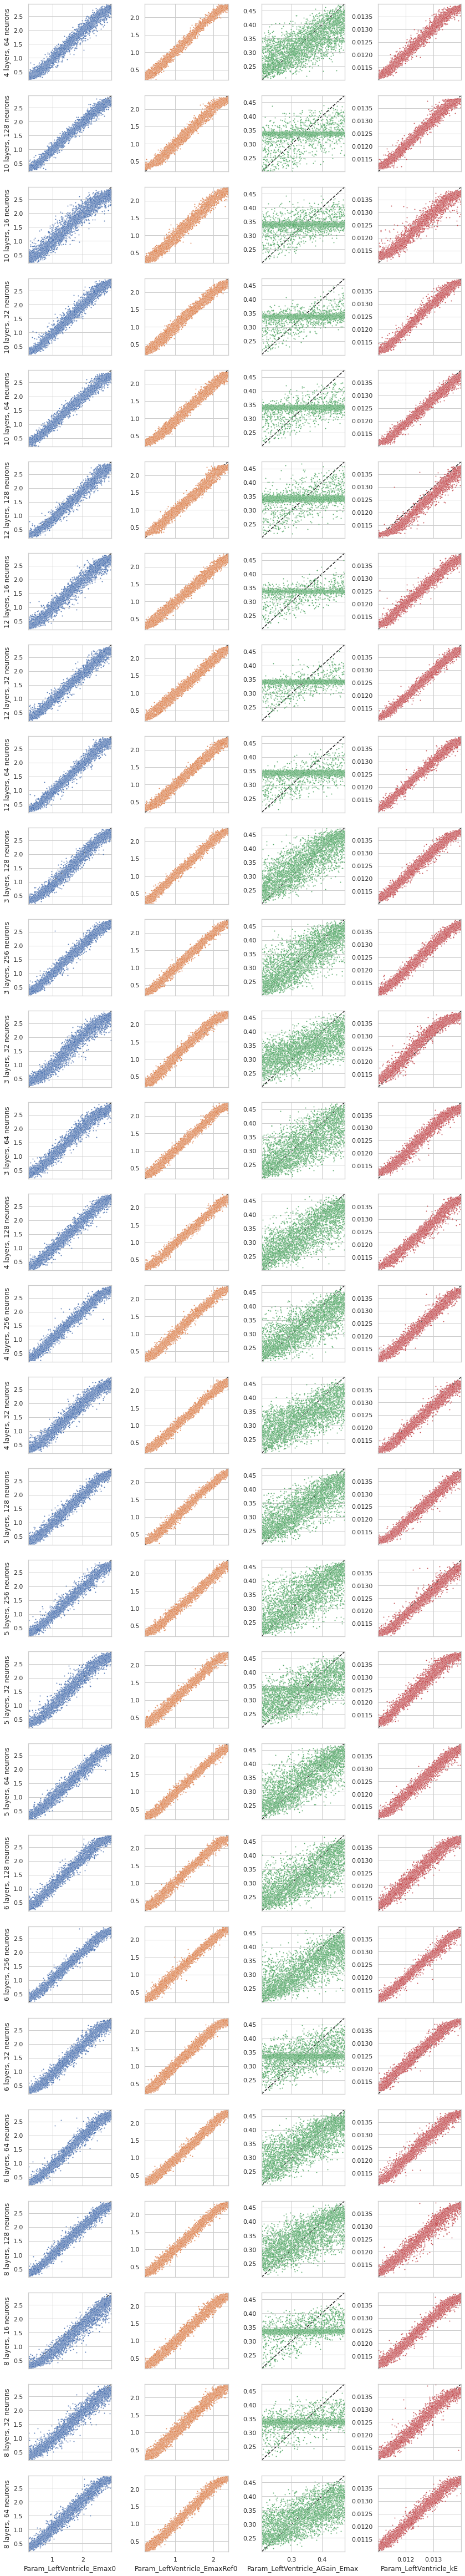

In [24]:
configs = df['desc'].unique()

fig, ax = plt.subplots(len(configs), 4, figsize=(14, len(configs)*3 + .5),
                       sharex='col', sharey='col')
colors = sns.color_palette(n_colors=4)

for i, config in enumerate(configs):
    for j, (var, a) in enumerate(zip(names, ax[i])):
        sns.scatterplot(data=df[df.desc == config].sample(frac=.3), x=var, y=f'{var}_hat', ax=a, color=colors[j], s=4)
        a.set_ylabel('')
        a.axis(**axes[var])
        a.plot([axes[var]['xmin'],axes[var]['xmax']], [axes[var]['ymin'], axes[var]['ymax']], '--k', zorder=0)

for conf, a in zip(configs, ax[:, 0]):
    a.set_ylabel(conf.replace('_', ' '))
    
plt.subplots_adjust(wspace=.4)
#plt.tight_layout()
plt.savefig('figs/dnn_comparison.pdf')

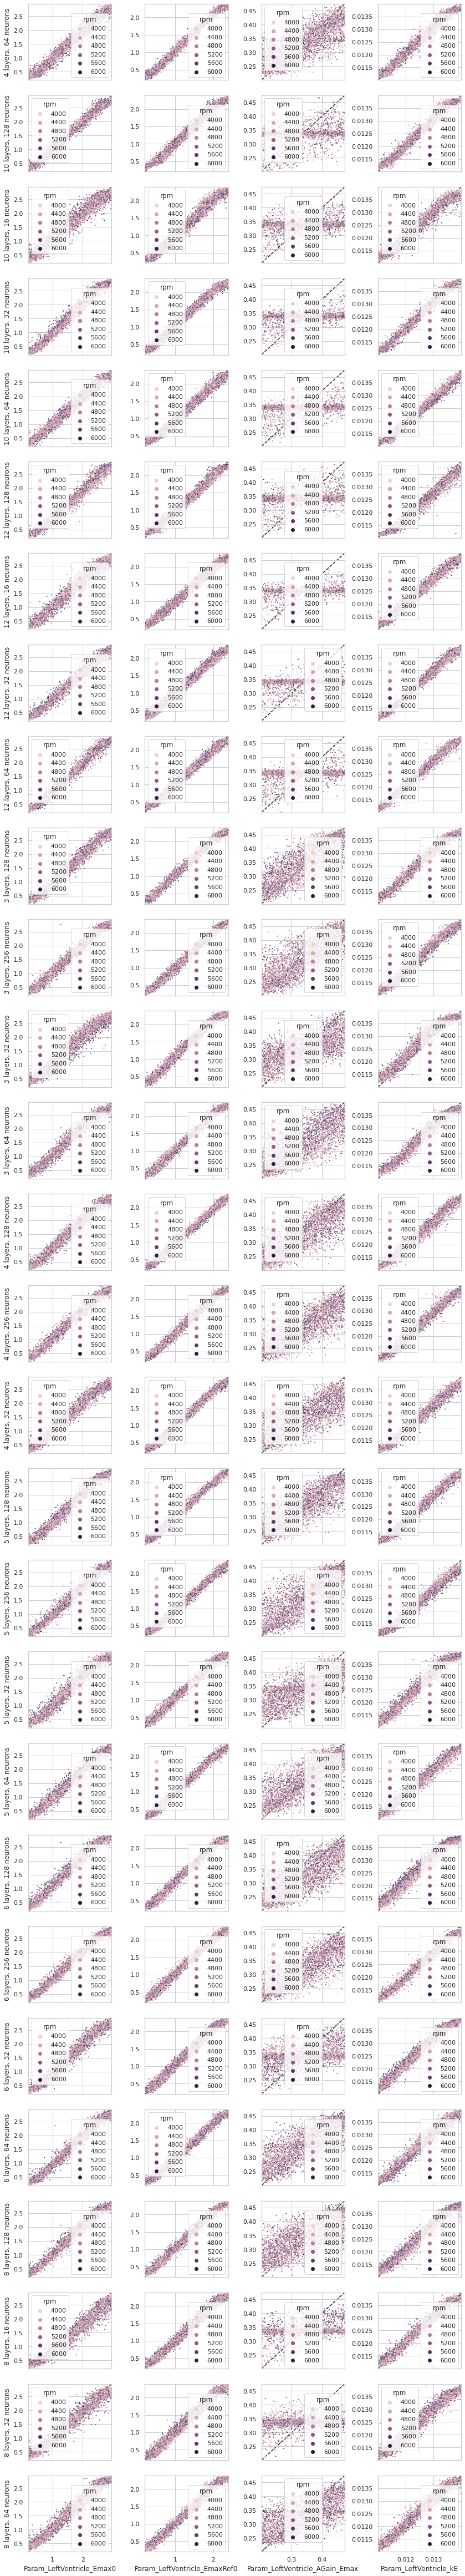

In [25]:
configs = df['desc'].unique()

fig, ax = plt.subplots(len(configs), 4, figsize=(14, len(configs)*3 + .5),
                       sharex='col', sharey='col')
colors = sns.color_palette(n_colors=4)

for i, config in enumerate(configs):
    for j, (var, a) in enumerate(zip(names, ax[i])):
        sns.scatterplot(data=df[df.desc == config].sample(frac=.3), x=var, y=f'{var}_hat', hue='rpm', ax=a, color=colors[j], s=4)
        a.set_ylabel('')
        a.axis(**axes[var])
        a.plot([axes[var]['xmin'],axes[var]['xmax']], [axes[var]['ymin'], axes[var]['ymax']], '--k', zorder=0)

for conf, a in zip(configs, ax[:, 0]):
    a.set_ylabel(conf.replace('_', ' '))
    
plt.subplots_adjust(wspace=.4)
#plt.tight_layout()
plt.savefig('figs/dnn_comparison_rpm.pdf')